In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
from datetime import datetime as dt
import pandas_market_calendars as mcal
import dateutil

In [2]:
# get range of dates from the last 100 days
import datetime
numdays = 100
# get current date
base = datetime.datetime.today()
# list comp for current date - number of days for range of dates
date_list = [base - datetime.timedelta(days=x) for x in range(numdays)]
# put into dataframe to do datetime formatting
dates = pd.DataFrame(date_list, columns = ['dates'])
dates['dates'] = pd.to_datetime(dates.dates)
dates['dates'] = dates['dates'].dt.strftime('%Y-%m-%d')
# sort dates ascending values
dates = dates.sort_values(by="dates", ascending=True)
# all dates are in a list to use in REST API to fetch data
dates = list(dates['dates'])

In [2]:
ticker = 'X:DOGEUSD'
range_agg = '/range/1/day/'
unadjusted = 'unadjusted=true'
sort = '&sort=asc'
limit = '&limit=50000'
POLYGON_URL = 'https://api.polygon.io/v2/aggs/ticker/'
from_date = '2013-12-06'
to_date = '2021-08-11'
POLYGON_API = '&apiKey=x6XqEaDjOWJXwVQRyBQ5kMEi8KlCYZqo'

In [3]:
datetime = []
open_price = []
high_price = []
low_price = []
close_price = []
volume = []
#for date in dates:
polygon = POLYGON_URL + ticker + range_agg + from_date + '/' + to_date + '?' + unadjusted + sort + limit + POLYGON_API
r_polygon = requests.get(polygon)
polygon_response = r_polygon.json()
for aggs in range(len(polygon_response['results'])):
    datetime.append(dt.fromtimestamp(polygon_response['results'][aggs]['t']/ 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
    open_price.append(polygon_response['results'][aggs]['o'])
    high_price.append(polygon_response['results'][aggs]['h'])
    low_price.append(polygon_response['results'][aggs]['l'])
    close_price.append(polygon_response['results'][aggs]['c'])
    volume.append(polygon_response['results'][aggs]['v'])

In [4]:
df = pd.DataFrame(list(zip(datetime,open_price,high_price,low_price, close_price,volume)),
columns =['datetime', 'open', 'high', 'low', 'close', 'volume'])

In [5]:
df.head()

,datetime,open,high,low,close,volume
0,2017-06-01 00:00:00,0.000100,0.000100,0.000100,0.000100,380.0
1,2017-06-02 00:00:00,0.120999,0.200000,0.000124,0.002803,123520.0
2,2017-06-03 00:00:00,0.002775,0.003398,0.002655,0.003213,1248350.0
3,2017-06-04 00:00:00,0.003242,0.003770,0.002544,0.003770,1703760.0
4,2017-06-05 00:00:00,0.003223,0.003825,0.002923,0.003718,1378090.0


In [6]:
len(df)

1533

In [7]:
df['datetime']

0       2017-06-01 00:00:00
1       2017-06-02 00:00:00
2       2017-06-03 00:00:00
3       2017-06-04 00:00:00
4       2017-06-05 00:00:00
               ...         
1528    2021-08-07 00:00:00
1529    2021-08-08 00:00:00
1530    2021-08-09 00:00:00
1531    2021-08-10 00:00:00
1532    2021-08-11 00:00:00
Name: datetime, Length: 1533, dtype: object

In [8]:
df.describe()

,open,high,low,close,volume
count,1533.000000,1533.000000,1533.000000,1533.000000,1.533000e+03
mean,0.027122,0.032146,0.021438,0.027368,3.715856e+08
std,0.079479,0.095781,0.058055,0.080886,7.008536e+08
min,0.000100,0.000100,0.000100,0.000100,3.800000e+02
25%,0.002307,0.002388,0.002215,0.002308,9.796479e+07
50%,0.002784,0.002881,0.002681,0.002785,1.900182e+08
75%,0.004561,0.004855,0.004235,0.004557,3.673047e+08
max,0.689090,0.740000,0.376900,0.690000,1.016595e+10


In [9]:
# Select only the important features i.e. the date and price
data = df[["datetime","close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
data = data.rename(columns = {"datetime":"ds","close":"y"}) #renaming the columns of the dataset
data.tail(5)

,ds,y
1528,2021-08-07 00:00:00,0.2603
1529,2021-08-08 00:00:00,0.2399
1530,2021-08-09 00:00:00,0.2562
1531,2021-08-10 00:00:00,0.2575
1532,2021-08-11 00:00:00,0.2650


In [10]:
from prophet import Prophet
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(data) # fit the model using all data

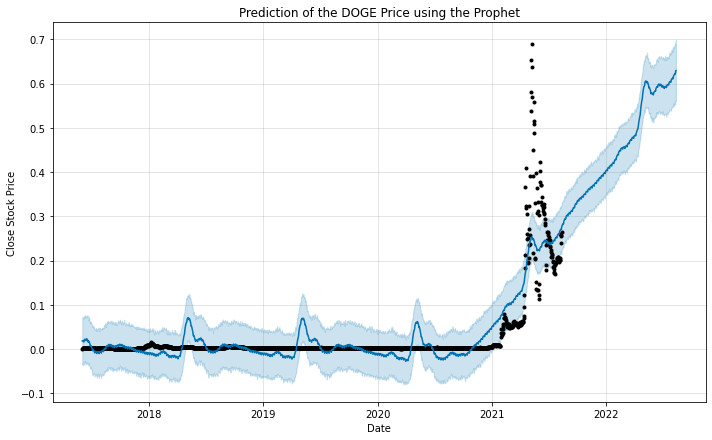

In [11]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the DOGE Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

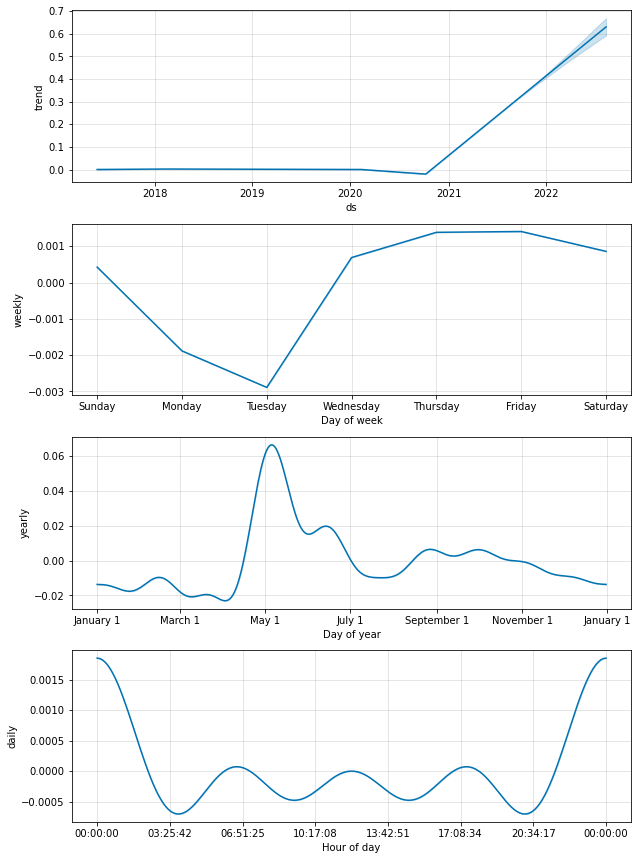

In [12]:
m.plot_components(prediction)
plt.show()

In [13]:
# try with some hyperparameter tuning
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation, performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 76 forecasts with cutoffs between 2018-06-13 00:00:00 and 2021-07-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ffb8230ad50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 76 forecasts with cutoffs between 2018-06-13 00:00:00 and 2021-07-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ffb822a31d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 76 forecasts with cutoffs between 2018-06-13 00:00:00 and 2021-07-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ffb823cd090>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_se

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.085486
1                     0.001                     0.10  0.085558
2                     0.001                     1.00  0.085941
3                     0.001                    10.00  0.085654
4                     0.010                     0.01  0.068333
5                     0.010                     0.10  0.068205
6                     0.010                     1.00  0.068200
7                     0.010                    10.00  0.067843
8                     0.100                     0.01  0.059462
9                     0.100                     0.10  0.058024
10                    0.100                     1.00  0.057982
11                    0.100                    10.00  0.057931
12                    0.500                     0.01  0.057895
13                    0.500                     0.10  0.060131
14                    0.500                     1.00  0

In [14]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


In [21]:
m = Prophet(daily_seasonality = True, changepoint_prior_scale=0.5, seasonality_prior_scale=0.01) # the Prophet class (model)
m.fit(data)

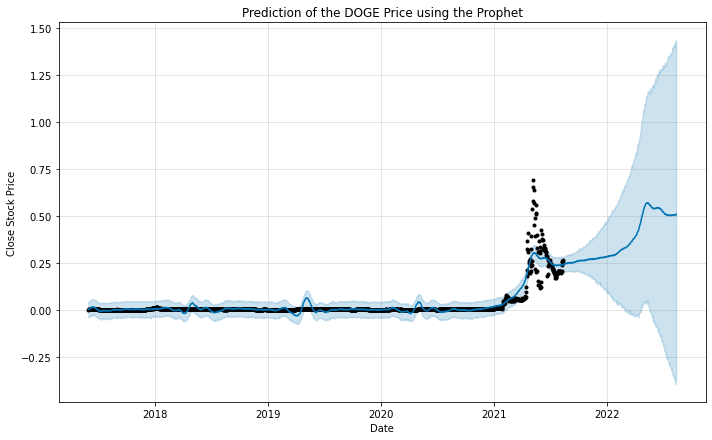

In [22]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the DOGE Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

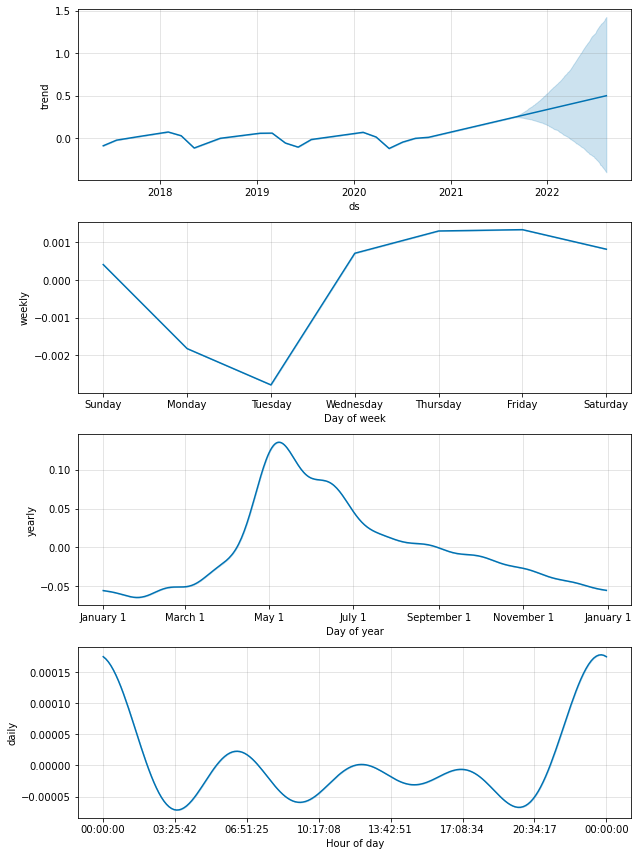

In [23]:
m.plot_components(prediction)
plt.show()